In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kruskal

In [14]:
# Load the dataset
df = pd.read_csv("WA_Marketing-Campaign.csv")

In [15]:
# Display the first 5 rows
print("First 5 rows:")
df.head()

First 5 rows:


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [16]:
# Basic dataset info
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [17]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


,0
MarketID,0
MarketSize,0
LocationID,0
AgeOfStore,0
Promotion,0
week,0
SalesInThousands,0


In [18]:
# Count of unique stores per promotion
store_counts = df.groupby("Promotion")["LocationID"].nunique()

store_counts

,LocationID
Promotion,
1,43
2,47
3,47


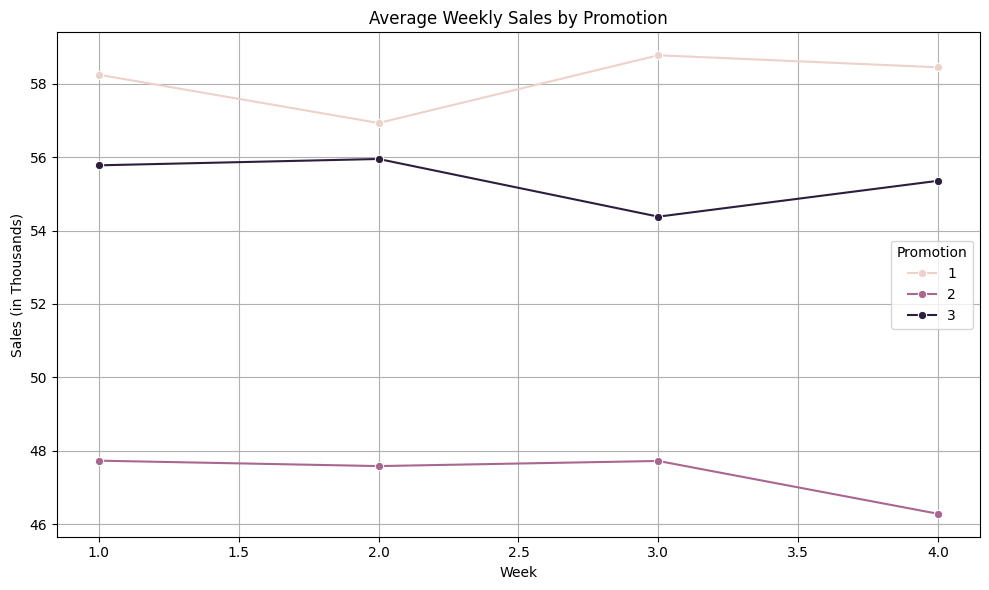

In [20]:
# Average sales per week per promotion
weekly_avg_sales = df.groupby(["Promotion", "week"])["SalesInThousands"].mean().reset_index()

# Plot: Average weekly sales per promotion
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_avg_sales, x="week", y="SalesInThousands", hue="Promotion", marker="o")
plt.title("Average Weekly Sales by Promotion")
plt.ylabel("Sales (in Thousands)")
plt.xlabel("Week")
plt.legend(title="Promotion")
plt.grid(True)
plt.tight_layout()
plt.show()

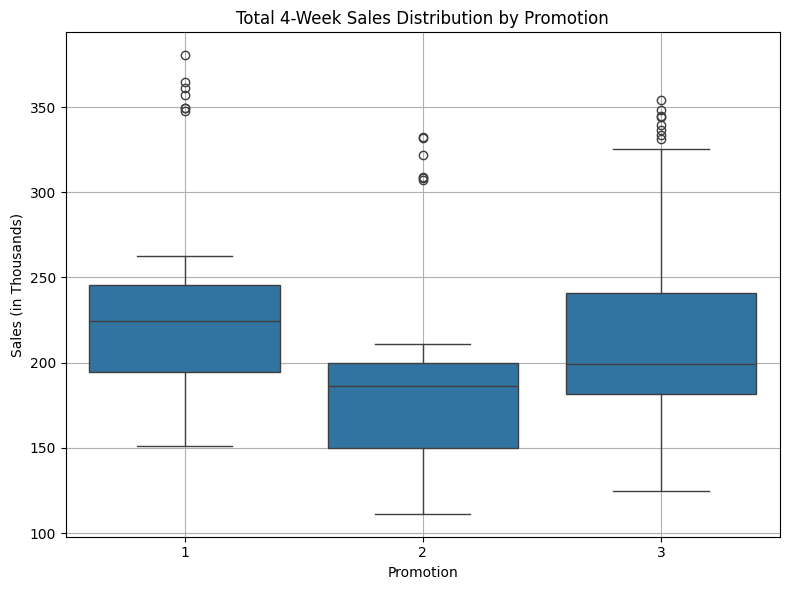

In [34]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=total_sales_per_store, x='Promotion', y='SalesInThousands')
plt.title('Total 4-Week Sales Distribution by Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales (in Thousands)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Total sales per store over all 4 weeks
total_sales_per_store = df.groupby(["LocationID", "Promotion"]).agg({
    "SalesInThousands": "sum",
    "MarketSize": "first",
    "AgeOfStore": "first"
}).reset_index()

In [22]:
total_sales_per_store.head()

,LocationID,Promotion,SalesInThousands,MarketSize,AgeOfStore
0,1,3,137.68,Medium,4
1,2,2,118.18,Medium,5
2,3,1,162.72,Medium,12
3,4,2,134.83,Medium,1
4,5,2,116.01,Medium,10


In [25]:
# Perform Shapiro-Wilk test for normality on total sales for each promotion group
# Null Hypothesis (H0): The data is drawn from a normally distributed population
# Alternative Hypothesis (H1): The data is not drawn from a normally distributed population

for group in total_sales_per_store['Promotion'].unique():
    stat, p = shapiro(total_sales_per_store[total_sales_per_store['Promotion'] == group]['SalesInThousands'])
    print(f"Promotion {group}: p-value = {p}")

Promotion 3: p-value = 0.00013465662878406974
Promotion 2: p-value = 2.3924814097272396e-05
Promotion 1: p-value = 0.0001570588078714794


In [27]:
# Separate the sales data for each promotion group
group1 = total_sales_per_store[total_sales_per_store['Promotion'] == 1]['SalesInThousands']
group2 = total_sales_per_store[total_sales_per_store['Promotion'] == 2]['SalesInThousands']
group3 = total_sales_per_store[total_sales_per_store['Promotion'] == 3]['SalesInThousands']

# Perform Levene’s test for equality of variances
# Null Hypothesis (H0): The variances are equal across all groups
# Alternative Hypothesis (H1): At least one group's variance is different from the others
stat, p = levene(group1, group2, group3)

print(f"Levene’s test p-value: {p}")

Levene’s test p-value: 0.6271730417231256


In [29]:
# Perform one-way ANOVA test
# Null Hypothesis (H0): The means of the groups are equal
# Alternative Hypothesis (H1): At least one group mean is different from the others
model = ols('SalesInThousands ~ C(Promotion)', data = total_sales_per_store).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                     sum_sq     df         F    PR(>F)
C(Promotion)   45796.697163    2.0  5.845792  0.003681
Residual      524886.746858  134.0       NaN       NaN


In [31]:
# Perform Tukey's Honestly Significant Difference (HSD) post hoc test
# This test is used for pairwise comparisons after ANOVA to see which specific groups differ
posthoc = pairwise_tukeyhsd(
    total_sales_per_store['SalesInThousands'], # Dependent variable (sales)
    total_sales_per_store['Promotion'],      # Independent variable (promotion group)
    alpha=0.05                                 # Significance level
)

print(posthoc.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -43.0784  0.004 -74.3806 -11.7762   True
     1      3 -10.9382 0.6862 -42.2404   20.364  False
     2      3  32.1402 0.0371   1.5415  62.7389   True
------------------------------------------------------


In [33]:
# Perform Kruskal-Wallis H test (non-parametric alternative to ANOVA)
# Null Hypothesis (H0): The medians of the groups are equal
# Alternative Hypothesis (H1): At least one group median is different from the others

stat, p = kruskal(group1, group2, group3)
print(f"Kruskal-Wallis p-value: {p}")

Kruskal-Wallis p-value: 0.00017274617006801915
